<a href="https://colab.research.google.com/github/Shayshu-NR/APS360-Final-Project/blob/main/APS360_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI APES


Yash IRL: <br>


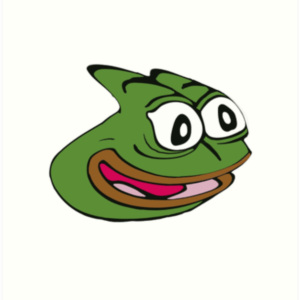

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchtext
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils
from textblob import TextBlob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 ! pip install -q kaggle

In [ ]:
! pip install -U textblob

Requirement already up-to-date: textblob in /usr/local/lib/python3.7/dist-packages (0.15.3)


In [ ]:
! python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shayshunahata","key":"3b81eb2692710006689ec29ddae395ba"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! ls ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

kaggle.json


In [ ]:
! kaggle datasets download -d stefanoleone992/imdb-extensive-dataset 

 94% 77.0M/82.3M [00:00<00:00, 98.0MB/s]
100% 82.3M/82.3M [00:00<00:00, 121MB/s] 


In [ ]:
! unzip /content/imdb-extensive-dataset.zip -d '/root/datasets'

Archive:  /content/imdb-extensive-dataset.zip
  inflating: /root/datasets/IMDb movies.csv  
  inflating: /root/datasets/IMDb names.csv  
  inflating: /root/datasets/IMDb ratings.csv  
  inflating: /root/datasets/IMDb title_principals.csv  


# Baseline Model


Extract the necessary info, clean up the data:

In [ ]:
movies = pd.read_csv('/root/datasets/IMDb movies.csv', index_col=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
movies

In [ ]:
catcols = ['genre', 'budget', 'country', 'duration', 'year', 'avg_vote']
df = movies[catcols]
not_missing = df.dropna()

In [ ]:
not_missing = not_missing[pd.to_numeric(not_missing['year']) > 1980]

In [ ]:
no_foreign = not_missing[not_missing['budget'].str[0] == '$']
no_foreign['budget'] = no_foreign['budget'].str.replace('$', '')

no_foreign['budget'] = no_foreign['budget'].astype('float')
no_foreign['duration'] = no_foreign['duration'].astype('float')
no_foreign['year'] = no_foreign['year'].astype('float')
no_foreign['avg_vote'] = no_foreign['avg_vote'].astype('float')

In [ ]:
no_foreign

Normalize the continuous data:

In [ ]:
# Normalize budget
cont_features = no_foreign[['budget', 'duration', 'year', 'avg_vote']]

normalized = no_foreign

normalized['budget']  = (normalized['budget'] - normalized['budget'].min()) / (normalized['budget'].max() - normalized['budget'].min()) 
normalized['duration']  = (normalized['duration'] - normalized['duration'].min()) / (normalized['duration'].max() - normalized['duration'].min()) 
normalized['year']  = (normalized['year'] - normalized['year'].min()) / (normalized['year'].max() - normalized['year'].min()) 
normalized['avg_vote']  = (normalized['avg_vote'] - normalized['avg_vote'].min()) / (normalized['avg_vote'].max() - normalized['avg_vote'].min()) 

In [ ]:
normalized_labels  = normalized[['avg_vote']]
normalized = normalized[['genre', 'budget', 'country', 'duration', 'year']]

In [ ]:
normalized


In [ ]:
data = pd.get_dummies(normalized)

In [ ]:
datanp = data.values.astype(np.float32)
labelnp = normalized_labels.values.astype(np.float32)

Create training and testing data sets:

In [ ]:
np.random.seed(1000)

np.random.shuffle(datanp)
np.random.shuffle(labelnp)

train_index = int(len(datanp) * 0.9)

train_set = datanp[:train_index]
test_set = datanp[train_index:]

train_label = labelnp[:train_index]
test_label = labelnp[train_index:]

In [ ]:
test_set.shape

(1336, 1968)

In [ ]:
test_label.shape

(1336, 1)

Use a premade model to make predictions

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [ ]:
from sklearn import linear_model
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

model = linear_model.SGDRegressor()
model.fit(train_set, train_label)

result = model.predict(test_set)


accuracy  = 0 
loss = 0
for i in range(len(result)):


  how_close = abs(result[i] - test_label[i])
  
  if how_close < 0.1 :
    accuracy += 1
  
  loss += (how_close)**2.0

plot_learning_curve(model, "Test", test_set, test_label)
print('Testing data performance', 100 * (accuracy / len(result)), '% correctly predicted')
print('Testing data performance', (loss / len(result)), 'Loss')

The testing accuracy of this model was 48.13%, with a mean squared loss of 0.024

# Primary Model

In [ ]:
class MovieDataset(torch.utils.data.Dataset):
  def __init__(self, data, labels):
    self.labels = labels
    self.data = data


  def __len__(self):
      return len(self.data)

  def __getitem__(self, index):
      # Load data and get label
      X = self.data[index]
      y = self.labels[index]

      return X, y

In [ ]:
movies = pd.read_csv('/root/datasets/IMDb movies.csv', index_col=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
catcols = ['genre', 'budget', 'country', 'duration', 'year', 'actors', 'director', 'description', 'avg_vote']
df = movies[catcols]
not_missing = df.dropna()

In [ ]:
year_dis = []
its = []

for i in range(114):
  year_dis.append(not_missing[not_missing.year == (1906 + i)].shape[0])
  its.append(i + 1906)

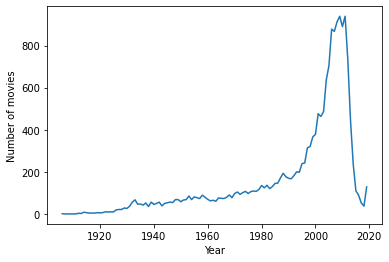

In [ ]:
plt.plot(its, year_dis)
plt.xlabel("Year")
plt.ylabel("Number of movies")
plt.show()

In [ ]:
unq_genres = np.sort(not_missing['avg_vote'].unique())
gen_breakd = []
nor_gen = []

for i in unq_genres:
  gen_breakd.append(not_missing[not_missing.avg_vote == i].shape[0])

# total = np.sum(gen_breakd)

# for i in gen_breakd:
#   nor_gen.append(100.0 * i / total)

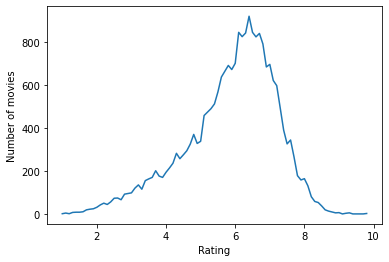

In [ ]:
plt.plot(unq_genres, gen_breakd)
plt.xlabel("Rating")
plt.ylabel("Number of movies")
plt.show()

In [ ]:
not_missing = not_missing[pd.to_numeric(not_missing['year']) > 1980]

In [ ]:
no_foreign = not_missing[not_missing['budget'].str[0] == '$']
no_foreign['budget'] = no_foreign['budget'].str.replace('$', '')

no_foreign['budget'] = no_foreign['budget'].astype('float')
no_foreign['duration'] = no_foreign['duration'].astype('float')
no_foreign['year'] = no_foreign['year'].astype('float')
no_foreign['avg_vote'] = no_foreign['avg_vote'].astype('float')

In [ ]:
# Normalize budget
cont_features = no_foreign[['budget', 'duration', 'year', 'avg_vote']]

normalized = no_foreign

normalized['budget']  = (normalized['budget'] - normalized['budget'].min()) / (normalized['budget'].max() - normalized['budget'].min()) 
normalized['duration']  = (normalized['duration'] - normalized['duration'].min()) / (normalized['duration'].max() - normalized['duration'].min()) 
normalized['year']  = (normalized['year'] - normalized['year'].min()) / (normalized['year'].max() - normalized['year'].min()) 
normalized['avg_vote']  = (normalized['avg_vote'] - normalized['avg_vote'].min()) / (normalized['avg_vote'].max() - normalized['avg_vote'].min()) 
normalized['polarity'] = normalized['description'].apply(lambda x: TextBlob(x).sentiment[0])
normalized['subjectivity'] = normalized['description'].apply(lambda x: TextBlob(x).sentiment[1])


In [ ]:
normalized['lead_actor']  = normalized['actors'].apply(lambda x: x.split(",")[0])
normalized['supporting_actor_1'] = normalized['actors'].apply(lambda x: x.split(",")[1] if len(x.split(",")) >= 2 else "")
normalized['supporting_actor_2'] = normalized['actors'].apply(lambda x: x.split(",")[2] if len(x.split(",")) >= 3 else "")

In [ ]:
#normalized_labels  = normalized[['avg_vote']]
#normalized = normalized[['genre', 'budget', 'country', 'duration', 'year', 'director', 'lead_actor', 'supporting_actor_1', 'supporting_actor_2', 'polarity', 'subjectivity']]
#normalized = normalized[['avg_vote','genre', 'budget', 'country', 'duration', 'year', 'director', 'lead_actor', 'supporting_actor_1', 'supporting_actor_2', 'polarity', 'subjectivity']]
#normalized = normalized[['avg_vote','genre', 'budget', 'country', 'duration', 'year', 'director', 'polarity', 'subjectivity']]
# normalized = normalized[['avg_vote','genre', 'budget', 'country', 'duration', 'year', 'polarity', 'subjectivity']]
normalized = normalized[['avg_vote','genre', 'budget', 'country', 'duration', 'year', 'polarity', 'subjectivity']]


In [ ]:
normalized

,avg_vote,genre,budget,country,duration,year,polarity,subjectivity
4334,0.609195,"Comedy, Fantasy, Romance",0.134831,USA,0.141264,0.512821,0.112121,0.251515
17164,0.448276,"Crime, Horror",0.002809,USA,0.107807,0.025641,-0.500000,0.750000
19430,0.402299,"Horror, Thriller",0.002809,USA,0.100372,0.025641,0.000000,0.000000
19691,0.678161,"Adventure, Comedy, Fantasy",0.014045,UK,0.137546,0.000000,0.100000,0.400000
19702,0.609195,"Drama, Family, Fantasy",0.000169,USA,0.089219,0.000000,0.234091,0.513636
...,...,...,...,...,...,...,...,...
85756,0.620690,"Drama, Horror, Romance",0.003371,Thailand,0.148699,0.974359,0.166667,0.233333
85773,0.425287,Action,0.008427,USA,0.092937,0.974359,0.023611,0.384722
85797,0.701149,Romance,0.000020,USA,0.092937,0.974359,0.700000,1.000000
85812,0.137931,Horror,0.001404,USA,0.065056,0.974359,0.400000,0.575000


In [ ]:
data = pd.get_dummies(normalized)

In [ ]:
data

,avg_vote,budget,duration,year,polarity,subjectivity,genre_Action,"genre_Action, Adventure","genre_Action, Adventure, Biography","genre_Action, Adventure, Comedy","genre_Action, Adventure, Crime","genre_Action, Adventure, Drama","genre_Action, Adventure, Family","genre_Action, Adventure, Fantasy","genre_Action, Adventure, History","genre_Action, Adventure, Horror","genre_Action, Adventure, Music","genre_Action, Adventure, Mystery","genre_Action, Adventure, Romance","genre_Action, Adventure, Sci-Fi","genre_Action, Adventure, Thriller","genre_Action, Adventure, War","genre_Action, Adventure, Western","genre_Action, Animation","genre_Action, Biography, Comedy","genre_Action, Biography, Crime","genre_Action, Biography, Drama","genre_Action, Biography, History","genre_Action, Biography, Western","genre_Action, Comedy","genre_Action, Comedy, Crime","genre_Action, Comedy, Drama","genre_Action, Comedy, Family","genre_Action, Comedy, Fantasy","genre_Action, Comedy, History","genre_Action, Comedy, Horror","genre_Action, Comedy, Music","genre_Action, Comedy, Musical","genre_Action, Comedy, Romance","genre_Action, Comedy, Sci-Fi",...,"country_USA, UK, South Africa","country_USA, UK, South Africa, Germany, France","country_USA, UK, Spain, South Korea","country_USA, UK, Taiwan, Japan, Mexico, Italy","country_USA, United Arab Emirates","country_USA, United Arab Emirates, Colombia, Spain","country_USA, United Arab Emirates, Czech Republic, India, Canada","country_USA, United Arab Emirates, Poland, India","country_USA, United Arab Emirates, UK","country_USA, West Germany","country_USA, West Germany, UK","country_USA, Yugoslavia","country_USA, Yugoslavia, Hong Kong",country_Uganda,country_Ukraine,"country_Ukraine, Russia","country_Ukraine, USA, Russia",country_United Arab Emirates,"country_United Arab Emirates, Jordan","country_United Arab Emirates, UK, India","country_United Arab Emirates, USA","country_United Arab Emirates, USA, France","country_United Arab Emirates, USA, India","country_United Arab Emirates, USA, Switzerland",country_Uruguay,"country_Uruguay, Argentina, Chile","country_Uruguay, Argentina, Cuba, Spain, Belgium","country_Uruguay, Argentina, Germany","country_Uruguay, Argentina, Germany, Spain","country_Uruguay, Mexico, France","country_Uruguay, Spain",country_Venezuela,"country_Venezuela, Cuba, France","country_Venezuela, Spain","country_Venezuela, Spain, Canada, Cuba",country_Vietnam,country_West Germany,"country_West Germany, USA",country_Yemen,"country_Yugoslavia, USA"
4334,0.609195,0.134831,0.141264,0.512821,0.112121,0.251515,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17164,0.448276,0.002809,0.107807,0.025641,-0.500000,0.750000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19430,0.402299,0.002809,0.100372,0.025641,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19691,0.678161,0.014045,0.137546,0.000000,0.100000,0.400000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19702,0.609195,0.000169,0.089219,0.000000,0.234091,0.513636,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85756,0.620690,0.003371,0.148699,0.974359,0.166667,0.233333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [ ]:
datanp = data.values.astype(np.float32)
# labelnp = normalized_labels.values.astype(np.float32)

In [ ]:
datanp.shape

(13249, 1958)

In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
np.random.shuffle(datanp)

train_index = int(len(datanp)*0.70)
val_index = int(len(datanp)*0.85)

train_set = datanp[:train_index]
val_set =  datanp[train_index:val_index]
test_set = datanp[val_index:]

train_label = datanp[:train_index]
val_label =  datanp[train_index:val_index]
test_label = datanp[val_index:]


In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True) 
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        self.name = "AutoEncoder"
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1958, 1000), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(1000, 500),

        )
        self.decoder = nn.Sequential(
            nn.Linear(500, 1000), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(1000, 1958),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
def zero_out_rating(records):
    records[:, 0] = 0
    return records

In [ ]:
# For the autoencoder
def get_accuracy(model, data_loader):
    total = 0
    acc = 0
    for item in data_loader: # minibatches
        inp = item.detach().numpy()
        out = model(zero_out_rating(item.clone())).detach().numpy()
        for i in range(out.shape[0]): # record in minibatch
            if out[i][0] <= inp[i][0] + 0.10 and out[i][0] >= inp[i][0] - 0.10:
              acc = acc + 1
            total += 1
    return acc / total

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path

In [ ]:
def train(model, train_loader, valid_loader, batch_size=32, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []
    n = 0 # the number of iterations
    k = 0
    j = 0
    val_iters, val_losses, acc_iters = [], [], []

    for epoch in range(num_epochs):

        for data in train_loader:
            #print(data)
            datam = zero_out_rating(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon[:,0], data[:,0])
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            n += 1
            

                #Calculating validation loss at the end of each epoch
        for data in valid_loader:
          datam = zero_out_rating(data.clone()) # zero out one categorical feature
          recon = model(datam)
          loss = criterion(recon[:,0], data[:,0])

          # save the current training information
          val_iters.append(k)
          val_losses.append(float(loss)/batch_size)             # compute *average* loss
          k += 1

        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
        # plotting the training loss every 20 iterations
        plt.title("Training Losses")
        plt.plot(iters, losses, label="Train")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()
        # plotting validation loss 
        plt.title("Validation Losses")
        plt.plot(val_iters, val_losses, label="Validation")
        plt.xlabel("Validation Iterations")
        plt.ylabel("Loss")
        plt.show()


        #Calculating training accuracy and validation accuarcy 
        acc_iters.append(j)
        j += 1
        val_acc.append(get_accuracy(model,valid_loader))
        train_acc.append(get_accuracy(model,train_loader))
        plt.title("Training Curve")
        plt.plot(acc_iters, train_acc, label="Training")
        plt.plot(acc_iters, val_acc, label="Validation")    
        plt.xlabel("Every 20 Iterations")
        plt.ylabel("Validation Accuracy")
        plt.legend(loc='best')
        plt.show()
        
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

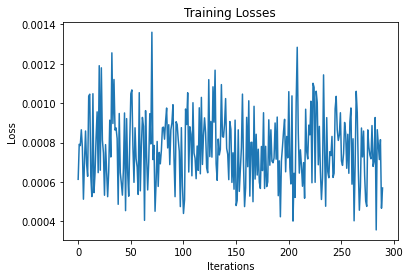

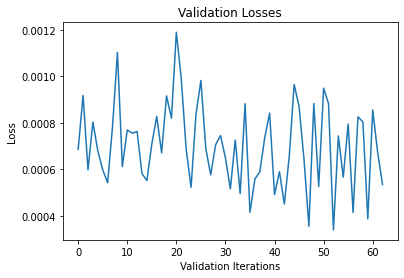

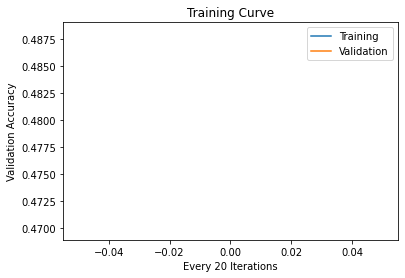

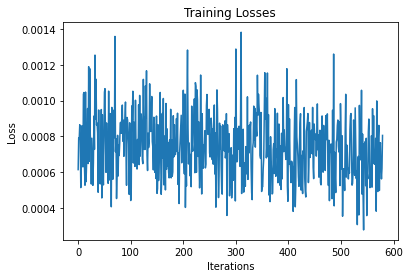

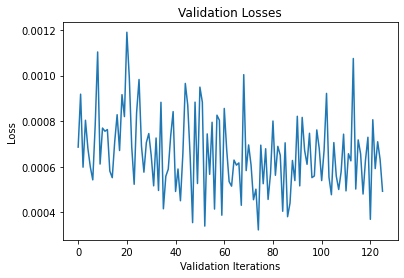

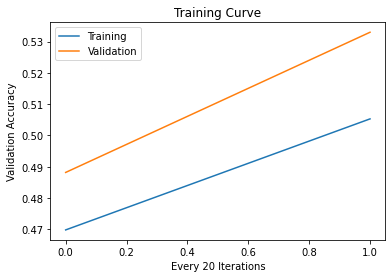

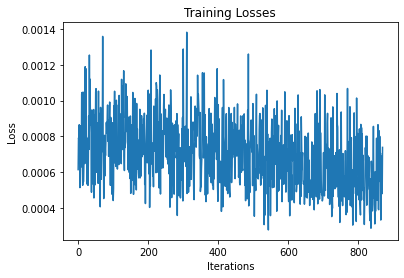

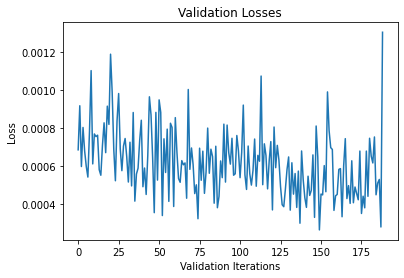

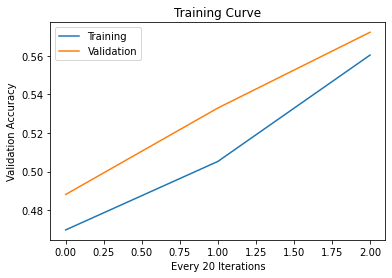

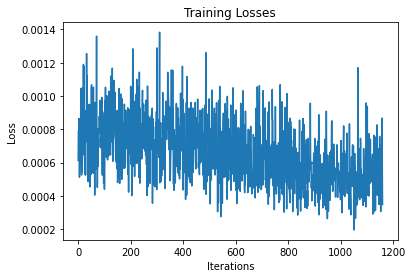

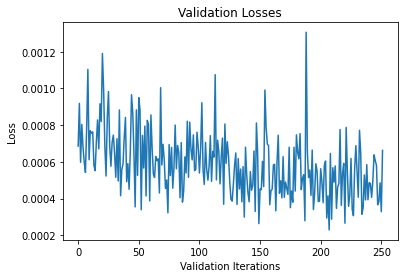

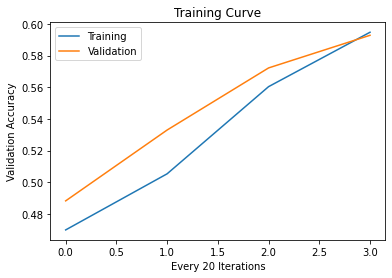

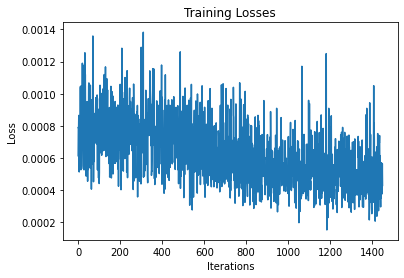

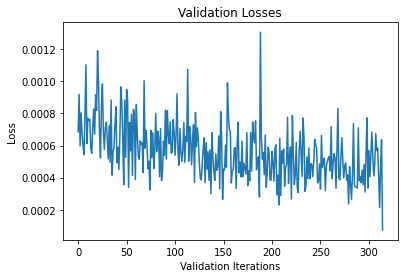

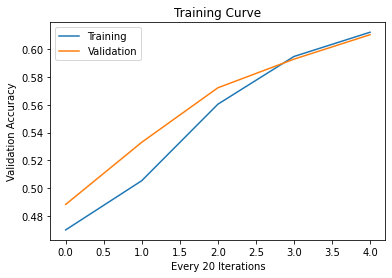

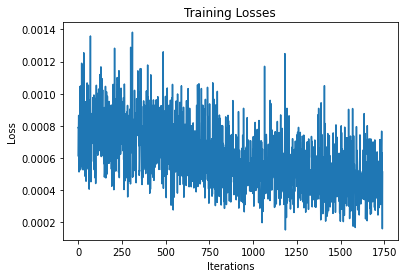

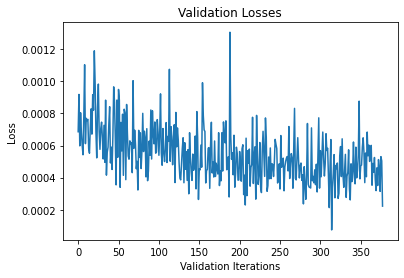

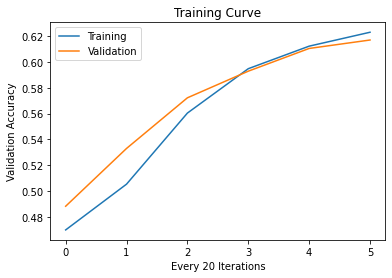

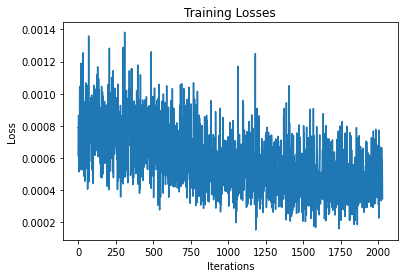

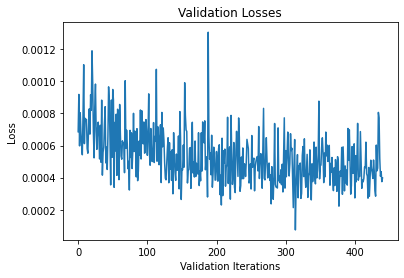

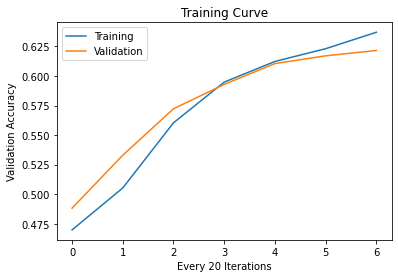

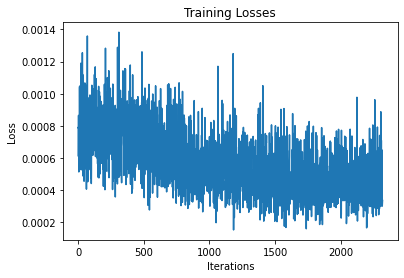

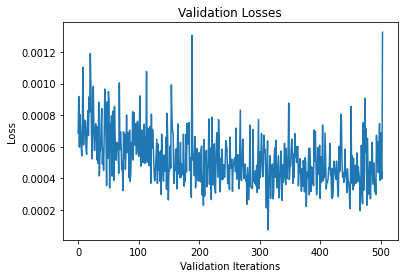

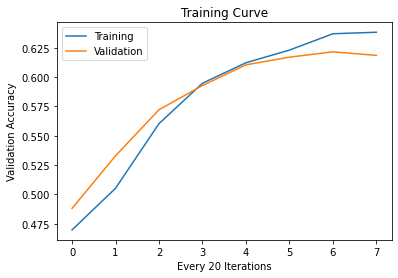

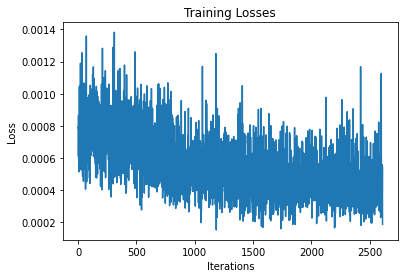

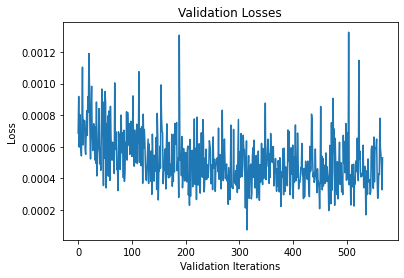

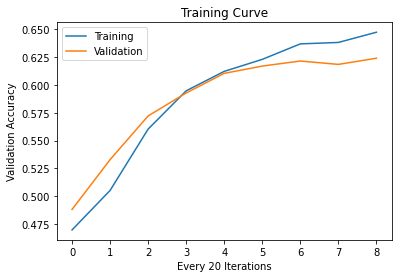

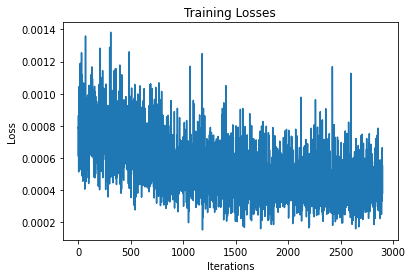

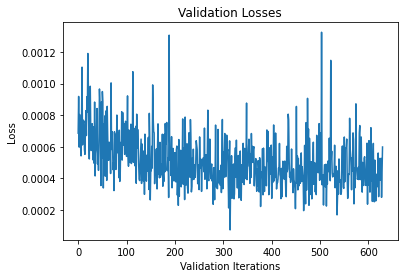

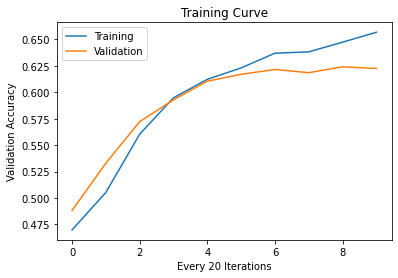

Final Training Accuracy: 0.6567824024153548
Final Validation Accuracy: 0.622546552591847


In [ ]:
MyModel = AutoEncoder()
train(MyModel, train_loader, val_loader,32 ,10, 1e-5)

In [ ]:
model = AutoEncoder()
model_path = model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name,32, 0.00001,9)
state = torch.load(model_path)
model.load_state_dict(state)
test_loader = torch.utils.data.DataLoader(test_set)
test_accuracy = get_accuracy(model, test_loader)
print("Test Accuracy: ", test_accuracy)

In [ ]:
# Godzilla Vs Kong movie from IMDb
# https://www.imdb.com/title/tt5034838/
godzilla_desc = 'The epic next chapter in the cinematic Monsterverse pits two of the greatest icons in motion picture history against one another - the fearsome Godzilla and the mighty Kong - with humanity caught in the balance.'
godzilla_year = (2021 - no_foreign['year'].min()) / (2021 - no_foreign['year'].min()) 
godzilla_dur = (113 - no_foreign['duration'].min()) / (no_foreign['duration'].max() - no_foreign['duration'].min()) 
godzilla_bud = (168000000- no_foreign['budget'].min()) / (no_foreign['budget'].max() - no_foreign['budget'].min())
godzilla_pol = TextBlob(godzilla_desc).sentiment[0]
godzilla_sub = TextBlob(godzilla_desc).sentiment[1]

# AI Adventures 
ai_desc = 'A wild ride filled with triumph and dispair. Four students, one project, will they be able to pass this course?'
ai_year = (1981 - no_foreign['year'].min()) / (2021 - no_foreign['year'].min()) 
ai_dur = (8 - no_foreign['duration'].min()) / (no_foreign['duration'].max() - no_foreign['duration'].min()) 
ai_bud = (16000- no_foreign['budget'].min()) / (no_foreign['budget'].max() - no_foreign['budget'].min())
ai_pol = TextBlob(ai_desc).sentiment[0]
ai_sub = TextBlob(ai_desc).sentiment[1]

# Create tensor to hold movie data
demo_tensor = torch.zeros((2, 1958))

In [ ]:
# Fill in tensor with cleaned data
demo_tensor[0, 0] = godzilla_bud
demo_tensor[0, 1] = godzilla_dur
demo_tensor[0, 2] = godzilla_year
demo_tensor[0, 3] = godzilla_pol
demo_tensor[0, 4] = godzilla_sub
demo_tensor[0, 95] = 1
demo_tensor[0, 1588] = 1

demo_tensor[1, 0] = ai_bud
demo_tensor[1, 1] = ai_dur
demo_tensor[1, 2] = ai_year
demo_tensor[1, 3] = ai_pol
demo_tensor[1, 4] = ai_sub
demo_tensor[1, 307] = 1
demo_tensor[1, 1588] = 1

In [ ]:
# Run Model on test data and extract the avg_vote column
model = AutoEncoder()
model_path = model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name,32, 1e-5, 9)
state = torch.load(model_path)
model.load_state_dict(state)

godzilla_result = model(demo_tensor[0])[0]
ai_result = model(demo_tensor[1])[0]

In [ ]:
# Unnormalize the data
godzilla_rating = (godzilla_result * (no_foreign['avg_vote'].max() - no_foreign['avg_vote'].min())) + no_foreign['avg_vote'].min()
ai_rating = (ai_result * (no_foreign['avg_vote'].max() - no_foreign['avg_vote'].min())) + no_foreign['avg_vote'].min()

In [ ]:
# Final results
print("Godzilla Vs. Kong predicted rating:", round(float(godzilla_rating),1))
print("AI Adventures predicted rating:", round(float(ai_rating),1))

Godzilla Vs. Kong predicted rating: 7.6
AI Adventures predicted rating: 5.3
